<a href="https://colab.research.google.com/github/Yog-Sothothe/DL-Project-3/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task *1* Basic test

In [1]:
!unzip TestDataSet.zip -d TestDataSet

Archive:  TestDataSet.zip
   creating: TestDataSet/TestDataSet/
   creating: TestDataSet/TestDataSet/n02795169/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/TestDataSet/n02769748/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/TestDataSet/n02834397/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/TestDataSet/n02917067/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/TestDataSet/n02808304/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/TestDataSet/n03016953/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/TestDataSet/n02793495/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/TestDataSet/n02814533/
  inflating: TestDataSet/__MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/TestDataSet/n02837789/
  inflating: TestDataSet

In [2]:
import json, itertools
with open("TestDataSet/TestDataSet/labels_list.json") as f:
    label_map_raw = json.load(f)
print(type(label_map_raw))
print(list(itertools.islice(label_map_raw, 5)))  # first few entries



<class 'list'>
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']


In [3]:
import json, os, torch, torchvision
from torchvision import transforms as T, datasets as dsets, models

INDEX_JSON = "imagenet_class_index.json"

# download once if the file isn't present
if not os.path.exists(INDEX_JSON):
    from torchvision.datasets.utils import download_url
    download_url(
        "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json",
        '.', INDEX_JSON
    )

with open(INDEX_JSON) as f:
    idx2info = json.load(f)

wnid_to_idx = {v[0]: int(k) for k, v in idx2info.items()}
# quick sanity
assert wnid_to_idx['n01440764'] == 0

# Dataset & loader
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

tfm = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])

root = "TestDataSet/TestDataSet"
dataset  = dsets.ImageFolder(root, transform=tfm)
loader   = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

subset_idx2wnid = {v: k for k, v in dataset.class_to_idx.items()}

# Model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

# Evaluation
top1 = top5 = tot = 0
for imgs, lbls in loader:
    out = model(imgs)
    _, preds5 = out.topk(5, 1)
    preds5 = preds5.cpu().numpy()

    for i, lbl in enumerate(lbls):
        wnid  = subset_idx2wnid[lbl.item()]
        true  = wnid_to_idx[wnid]
        p5    = preds5[i]

        top1 += (p5[0] == true)
        top5 += (true in p5)
    tot += lbls.size(0)

print(f"Top‑1 accuracy: {top1/tot:.2%}")
print(f"Top‑5 accuracy: {top5/tot:.2%}")


100%|██████████| 35.4k/35.4k [00:00<00:00, 427kB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 194MB/s]


Top‑1 accuracy: 70.40%
Top‑5 accuracy: 93.20%


# Task 2  Fast Gradient Sign Method (FGSM) Attack (ε = 0.02)

In [4]:
import torch
import torch.nn.functional as F

# 1) Pick device and push model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device).eval()

# 2) Build your budget & bounds ON the device
EPS_NORM = 0.02                               # normalized‐space budget
eps      = torch.full((1, 3, 1, 1), EPS_NORM, device=device)
mean     = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std      = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

min_norm = (0 - mean) / std                    # valid lower bound
max_norm = (1 - mean) / std                    # valid upper bound

adv_imgs   = []
adv_labels = []

# 3) Loop over your clean loader (wrap it in GPU if you want)
for images, labels in loader:
    # Move data to GPU
    images, labels = images.to(device), labels.to(device)
    images = images.clone().detach().requires_grad_()

    # Forward + backward
    logits = model(images)
    true_idx = torch.tensor([wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],device=device)
    loss   = F.cross_entropy(logits, true_idx)
    model.zero_grad()
    loss.backward()

    # FGSM step (normalized‐space)
    adv = images + eps * images.grad.sign()
    # Project into valid pixel range
    adv = torch.max(torch.min(adv, max_norm), min_norm)

    adv_imgs.append(adv.detach().cpu())        # detach & back to CPU for storage
    adv_labels.append(labels.detach().cpu())

# 4) Concatenate into final tensors on CPU
adv_dataset_images_task2 = torch.cat(adv_imgs,   dim=0)
adv_dataset_labels_task2 = torch.cat(adv_labels, dim=0)



Using device: cuda


In [5]:
print(adv_dataset_images_task2.shape)
print(adv_dataset_labels_task2.shape)

torch.Size([500, 3, 224, 224])
torch.Size([500])


In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Pick your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Move model
model.to(device)
model.eval()

# 3. Wrap your adversarial dataset
adv_dataset = TensorDataset(adv_dataset_images_task2, adv_dataset_labels_task2)
adv_loader  = DataLoader(adv_dataset, batch_size=32, shuffle=False)

# 4. Evaluation loop on GPU
top1 = top5 = tot = 0
with torch.no_grad():
    for imgs, lbls in adv_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)       # <- move to GPU
        logits     = model(imgs)
        _, preds5  = logits.topk(5, 1)
        preds5     = preds5.cpu().numpy()                   # back to CPU for numpy ops

        for i, lbl in enumerate(lbls.cpu()):                 # lbls.cpu() because subset_idx2wnid is CPU dict
            wnid = subset_idx2wnid[lbl.item()]
            true = wnid_to_idx[wnid]
            p5   = preds5[i]

            top1 += (p5[0] == true)
            top5 += (true in p5)
        tot += lbls.size(0)

print(f"FGSM top-1 accuracy: {top1/tot:.2%}")
print(f"FGSM top-5 accuracy: {top5/tot:.2%}")


Using device: cuda
FGSM top-1 accuracy: 5.00%
FGSM top-5 accuracy: 30.20%


## Visualize adversarial examples

In [10]:
orig_images_list = []
orig_labels_list = []
for images, labels in loader:
  orig_images_list.append(images)
  orig_labels_list.append(labels)

orig_dataset_images = torch.cat(orig_images_list)
orig_dataset_labels = torch.cat(orig_labels_list)

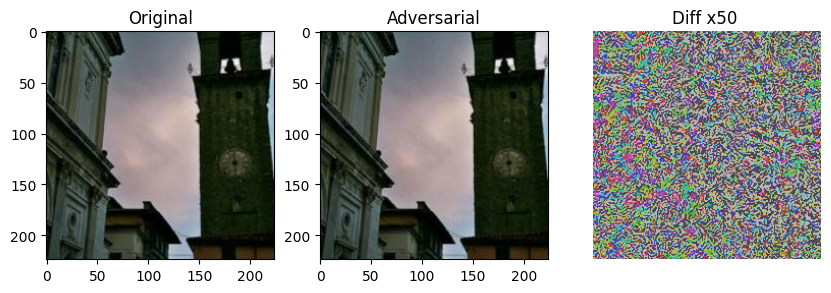

In [12]:
import torch, numpy as np, matplotlib.pyplot as plt

MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def tensor_to_image(t):
    img = t.detach().cpu()           # CHW, still normalized
    img = img * STD + MEAN           # denormalize in one shot
    img = img.clamp(0,1)
    return img.permute(1,2,0).numpy()   # HWC for matplotlib

idx = 42                               # any index that actually exists
orig_img = tensor_to_image(orig_dataset_images[idx])
adv_img  = tensor_to_image(adv_dataset_images_task2[idx])

diff_img = np.clip((orig_img - adv_img)*50 + 0.5, 0, 1)  # boost & shift

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(orig_img); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(adv_img);  plt.title("Adversarial")
plt.subplot(1,3,3); plt.imshow(diff_img); plt.title("Diff x50 ")
plt.axis('off')
plt.show()


# Task 3 Improved attacks


# multiple gradient steps

In [13]:
import torch
import torch.nn.functional as F

# 1) Device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device).eval()

# 2) Budget & bounds on device
EPS_NORM = 0.02                              # total L∞ budget in normalized space
STEPS    = 10                                # number of PGD iterations
ALPHA    = EPS_NORM/STEPS                # step size per iteration

mean     = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std      = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
min_norm = (0 - mean) / std                  # clamp low
max_norm = (1 - mean) / std                  # clamp high

# 3) Prepare storage
adv_imgs   = []
adv_labels = []

# 4) PGD loop over dataset
for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    orig = images.clone().detach()           # save original for projection
    adv  = orig.clone()                      # initialize adv = original

    # iterative attack
    for _ in range(STEPS):
        adv.requires_grad_()
        logits = model(adv)
        true_idx = torch.tensor([wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],device=device)
        loss   = F.cross_entropy(logits, true_idx)
        model.zero_grad()
        loss.backward()

        # gradient step
        adv = adv + ALPHA * adv.grad.sign()

        # project back into L∞ ball around orig
        adv = torch.max(torch.min(adv, orig + EPS_NORM), orig - EPS_NORM)
        # clamp to valid pixel range
        adv = torch.max(torch.min(adv, max_norm), min_norm).detach()

    # collect
    adv_imgs.append(adv.cpu())
    adv_labels.append(labels.cpu())

# 5) build final adversarial tensors
adv_dataset_images_task3 = torch.cat(adv_imgs,   dim=0)
adv_dataset_labels_task3 = torch.cat(adv_labels, dim=0)

Using device: cuda


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Pick your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Move model
model.to(device)
model.eval()

# 3. Wrap your adversarial dataset
adv_dataset = TensorDataset(adv_dataset_images_task3, adv_dataset_labels_task3)
adv_loader  = DataLoader(adv_dataset, batch_size=32, shuffle=False)

# 4. Evaluation loop on GPU
top1 = top5 = tot = 0
with torch.no_grad():
    for imgs, lbls in adv_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)       # <- move to GPU
        logits     = model(imgs)
        _, preds5  = logits.topk(5, 1)
        preds5     = preds5.cpu().numpy()                   # back to CPU for numpy ops

        for i, lbl in enumerate(lbls.cpu()):                 # lbls.cpu() because subset_idx2wnid is CPU dict
            wnid = subset_idx2wnid[lbl.item()]
            true = wnid_to_idx[wnid]
            p5   = preds5[i]

            top1 += (p5[0] == true)
            top5 += (true in p5)
        tot += lbls.size(0)

print(f"FGSM top-1 accuracy: {top1/tot:.2%}")
print(f"FGSM top-5 accuracy: {top5/tot:.2%}")

Using device: cuda
FGSM top-1 accuracy: 0.20%
FGSM top-5 accuracy: 10.40%


In [15]:
# reload originals
orig_imgs = []
for imgs, _ in loader:
    orig_imgs.append(imgs)    # these are already normalized
orig_imgs = torch.cat(orig_imgs, dim=0)

# compare
diff = (adv_dataset_images_task3 - orig_imgs).abs()
max_per_image = diff.view(diff.size(0), -1).max(dim=1).values

print(f"Max ε across dataset:   {max_per_image.max().item():.4f}")
print(f"Mean ε across dataset:  {max_per_image.mean().item():.4f}")
assert max_per_image.max() <= EPS_NORM + 1e-6



Max ε across dataset:   0.0200
Mean ε across dataset:  0.0200


# targeted attacks

In [16]:
adv_imgs, adv_labels, adv_targets = [], [], []   # NEW: store targets too

EPS_NORM = 0.02                              # total L∞ budget in normalized space
STEPS    = 50                                # number of PGD iterations
ALPHA    = EPS_NORM/STEPS                # step size per iteration

for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    orig = images.clone().detach()
    adv  = orig.clone()

    # per‑image “next‑class” targets
    true_idx   = torch.tensor(
        [wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],
        device=device
    )
    target_idx = (true_idx + 1) % 1000           # [B]

    for _ in range(STEPS):
        adv.requires_grad_()
        loss = F.cross_entropy(model(adv), target_idx)  # minimise CE to targets
        model.zero_grad()
        loss.backward()
        adv = adv - ALPHA * adv.grad.sign()             # targeted PGD step
        adv = torch.max(torch.min(adv, orig + EPS_NORM), orig - EPS_NORM)
        adv = torch.max(torch.min(adv, max_norm),       min_norm).detach()

    # collect this batch
    adv_imgs.append(adv.cpu())
    adv_labels.append(true_idx.cpu())
    adv_targets.append(target_idx.cpu())     # ← NEW

# build tensors
adv_dataset_images_task3_targeted  = torch.cat(adv_imgs,    dim=0)    # [N,3,224,224]
adv_dataset_labels_task3_targeted = torch.cat(adv_labels, dim=0)
adv_dataset_targets_task3_targeted = torch.cat(adv_targets, dim=0)    # [N]

# evaluate targeted success
with torch.no_grad():
    preds = model(adv_dataset_images_task3_targeted.to(device)).argmax(1).cpu()
hit_rate = (preds == adv_dataset_targets_task3_targeted).float().mean().item()

print(f"Per‑image targeted success rate: {hit_rate:.2%}")


Per‑image targeted success rate: 86.00%


In [17]:
with torch.no_grad():
    logits     = model(adv_dataset_images_task3_targeted.to(device))
    top1_pred  = logits.argmax(1).cpu()
    top5_pred  = logits.topk(5, 1).indices.cpu()

true_idx = adv_dataset_labels_task3_targeted
# accuracies
top1_hits = (top1_pred == true_idx)
top5_hits = torch.any(top5_pred == true_idx.unsqueeze(1), dim=1)

top1_acc  = top1_hits.float().mean().item()
top5_acc  = top5_hits.float().mean().item()

# targeted success
tgt_idx   = adv_dataset_targets_task3_targeted
tgt_hits  = (top1_pred == tgt_idx)
tgt_rate  = tgt_hits.float().mean().item()

print(f"Top‑1 accuracy on adversarial set : {top1_acc:.2%}")
print(f"Top‑5 accuracy on adversarial set : {top5_acc:.2%}")
print(f"Targeted success rate             : {tgt_rate:.2%}")

Top‑1 accuracy on adversarial set : 5.00%
Top‑5 accuracy on adversarial set : 35.40%
Targeted success rate             : 86.00%


# Task 4: Patch attacks

## 1. untargeted

In [18]:
PATCH      = 32        # square patch size (H = W = 32)
EPS_NORM   = 0.5      # L∞ budget *inside the patch* (normalised space)
STEPS      = 50
ALPHA      = EPS_NORM / STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
min_norm = (0 - mean) / std
max_norm = (1 - mean) / std
# -------------------------------------------------------

adv_imgs, adv_labels = [], []

for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    B, _, H, W = images.shape

    # build one random square patch per image
    # top‑left (y,x) coordinates in [0, H‑PATCH]
    coords = torch.randint(0, H-PATCH+1, (B, 2), device=device)
    # binary mask: 1 inside patch, 0 elsewhere
    mask = torch.zeros((B, 1, H, W), device=device)
    for i, (yy, xx) in enumerate(coords):
        mask[i, :, yy:yy+PATCH, xx:xx+PATCH] = 1
    mask_bool = mask.bool()

    # initialise PGD
    orig = images.clone().detach()
    adv  = orig.clone()

    # untargeted patch‑PGD loop
    true_idx = torch.tensor([wnid_to_idx[subset_idx2wnid[l.item()]]
                             for l in labels], device=device)

    for _ in range(STEPS):
        adv.requires_grad_()
        loss = F.cross_entropy(model(adv), true_idx)   # maximise loss (untargeted)
        model.zero_grad()
        loss.backward()

        # gradient ascent only *inside* the patch
        grad_sign = adv.grad.sign() * mask
        adv = adv + ALPHA * grad_sign

        # project so that |adv−orig|≤ε inside the patch, else keep orig
        pert = torch.clamp(adv - orig, min=-EPS_NORM, max=EPS_NORM)
        adv  = torch.where(mask_bool, orig + pert, orig)

        # clip to valid range
        adv = torch.max(torch.min(adv, max_norm), min_norm).detach()

    adv_imgs.append(adv.cpu())
    adv_labels.append(labels.cpu())

# build adversarial dataset
adv_dataset_images_task4_untargeted = torch.cat(adv_imgs, dim=0)
adv_dataset_labels_task4_untargeted = torch.cat(adv_labels, dim=0)

# evaluate top‑1 / top‑5
top1 = top5 = tot = 0
model.eval()
with torch.no_grad():
    for i in range(0, len(adv_dataset_images_task4_untargeted), 32):
        batch = adv_dataset_images_task4_untargeted[i:i+32].to(device)
        out   = model(batch)
        _, p5 = out.topk(5, 1)
        p5    = p5.cpu().numpy()

        for j in range(p5.shape[0]):
            true = wnid_to_idx[subset_idx2wnid[adv_dataset_labels_task4_untargeted[i+j].item()]]
            top1 += (p5[j, 0] == true)
            top5 += (true in p5[j])
        tot += p5.shape[0]

print(f"Patch‑PGD untargeted top‑1 accuracy: {top1/tot:.2%}")
print(f"Patch‑PGD untargeted top‑5 accuracy: {top5/tot:.2%}")


Patch‑PGD untargeted top‑1 accuracy: 35.80%
Patch‑PGD untargeted top‑5 accuracy: 71.40%


## 2. targeted

In [19]:
import torch, torch.nn.functional as F
from torchvision import models, transforms as T, datasets as dsets

MEAN = [0.485, 0.456, 0.406];  STD = [0.229, 0.224, 0.225]
tfm = T.Compose([T.Resize(256), T.CenterCrop(224),
                 T.ToTensor(), T.Normalize(MEAN, STD)])

root = "TestDataSet/TestDataSet"
dataset = dsets.ImageFolder(root, transform=tfm)
loader  = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)\
          .to(device).eval()

# hyper‑parameters
PATCH      = 32
EPS_NORM   = 0.5
STEPS      = 50
ALPHA      = EPS_NORM / STEPS

mean = torch.tensor(MEAN, device=device).view(1,3,1,1)
std  = torch.tensor(STD,  device=device).view(1,3,1,1)
min_norm = (0 - mean) / std
max_norm = (1 - mean) / std

adv_imgs, adv_labels, adv_targets = [], [], []

for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    B, _, H, W = images.shape

    # pick target per image
    true_idx = torch.tensor(
        [wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],
        device=device
    )
    target_idx = (true_idx + 1) % 500                  # next class

    # one random 32×32 patch per image
    coords = torch.randint(0, H-PATCH+1, (B, 2), device=device)
    mask   = torch.zeros((B, 1, H, W), device=device)
    for i, (yy, xx) in enumerate(coords):
        mask[i, :, yy:yy+PATCH, xx:xx+PATCH] = 1
    mask_bool = mask.bool()

    orig = images.clone().detach()
    adv  = orig.clone()

    # targeted patch‑PGD loop
    for _ in range(STEPS):
        adv.requires_grad_()
        loss = F.cross_entropy(model(adv), target_idx)  # minimise to target
        model.zero_grad();  loss.backward()

        grad_sign = adv.grad.sign() * mask              # perturb inside patch
        adv = adv - ALPHA * grad_sign

        pert = torch.clamp(adv - orig, -EPS_NORM, EPS_NORM)
        adv  = torch.where(mask_bool, orig + pert, orig)
        adv  = torch.max(torch.min(adv, max_norm), min_norm).detach()

    adv_imgs.append(adv.cpu())
    adv_labels.append(true_idx.cpu())
    adv_targets.append(target_idx.cpu())

adv_dataset_images_task4_1  = torch.cat(adv_imgs,    dim=0)
adv_dataset_labels_task4_1  = torch.cat(adv_labels,  dim=0)
adv_dataset_targets_task4_1 = torch.cat(adv_targets, dim=0)

# evaluate
top1_acc = top5_acc = 0               # normal accuracy
top1_tgt = top5_tgt = 0               # targeted success
BATCH = 32

with torch.no_grad():
    for i in range(0, len(adv_dataset_images_task4_1), BATCH):
        imgs   = adv_dataset_images_task4_1[i:i+BATCH].to(device)
        logits = model(imgs)
        preds5 = logits.topk(5, 1).indices.cpu()

        true   = adv_dataset_labels_task4_1[i:i+BATCH]
        tgt    = adv_dataset_targets_task4_1[i:i+BATCH]

        # accuracy
        top1_acc += (preds5[:, 0] == true).sum().item()
        top5_acc += (preds5 == true.unsqueeze(1)).any(1).sum().item()

        # targeted success
        top1_tgt += (preds5[:, 0] == tgt).sum().item()
        top5_tgt += (preds5 == tgt.unsqueeze(1)).any(1).sum().item()

N = len(adv_dataset_images_task4_1)
print(f"Accuracy on adversarial images  — Top‑1: {top1_acc/N:.2%}, Top‑5: {top5_acc/N:.2%}")
print(f"Targeted‑attack success rate    — Top‑1: {top1_tgt/N:.2%}, Top‑5: {top5_tgt/N:.2%}")

Accuracy on adversarial images  — Top‑1: 65.80%, Top‑5: 90.60%
Targeted‑attack success rate    — Top‑1: 4.00%, Top‑5: 11.00%


### 2.1 Try nearest neighbor instead of next class for target

In [20]:
import torch, torch.nn.functional as F
from torchvision import models, transforms as T, datasets as dsets

MEAN = [0.485, 0.456, 0.406];  STD = [0.229, 0.224, 0.225]
tfm = T.Compose([T.Resize(256), T.CenterCrop(224),
                 T.ToTensor(), T.Normalize(MEAN, STD)])

root = "TestDataSet/TestDataSet"
dataset = dsets.ImageFolder(root, transform=tfm)
loader  = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)\
          .to(device).eval()

# hyper‑parameters
PATCH      = 32
EPS_NORM   = 0.5
STEPS      = 50
ALPHA      = EPS_NORM / STEPS

mean = torch.tensor(MEAN, device=device).view(1,3,1,1)
std  = torch.tensor(STD,  device=device).view(1,3,1,1)
min_norm = (0 - mean) / std
max_norm = (1 - mean) / std

adv_imgs, adv_labels, adv_targets = [], [], []

for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    B, _, H, W    = images.shape

    orig = images.clone().detach()
    # now orig.shape[0] == B

    # 1) margin‐based target selection
    with torch.no_grad():
        logits_clean = model(orig)
        true_idx     = torch.tensor(
            [wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],
            device=device
        )
        # true_scores: [B,1]
        true_scores  = logits_clean.gather(1, true_idx.unsqueeze(1))
        # margins: [B,1000]
        margins      = true_scores - logits_clean
        margins[torch.arange(B), true_idx] = float('inf')
        target_idx   = margins.argmin(dim=1)   # [B]

    # 2) build patch mask
    coords = torch.randint(0, H-PATCH+1, (B,2), device=device)
    mask   = torch.zeros((B,1,H,W), device=device)
    for i,(yy,xx) in enumerate(coords):
        mask[i,:,yy:yy+PATCH, xx:xx+PATCH] = 1
    mask_bool = mask.bool()

    adv = orig.clone()

    # 3) targeted patch PGD
    for _ in range(STEPS):
        adv.requires_grad_()
        loss  = F.cross_entropy(model(adv), target_idx)
        model.zero_grad(); loss.backward()

        grad_sign = adv.grad.sign() * mask
        adv       = adv - ALPHA * grad_sign

        pert = torch.clamp(adv - orig, -EPS_NORM, EPS_NORM)
        adv  = torch.where(mask_bool, orig + pert, orig)
        adv  = torch.max(torch.min(adv, max_norm), min_norm).detach()

    # 4) collect
    adv_imgs.append(adv.cpu())
    adv_labels.append(true_idx.cpu())
    adv_targets.append(target_idx.cpu())

adv_dataset_images  = torch.cat(adv_imgs,    dim=0)
adv_dataset_labels  = torch.cat(adv_labels,  dim=0)
adv_dataset_targets = torch.cat(adv_targets, dim=0)

# evaluate
top1_acc = top5_acc = 0               # normal accuracy
top1_tgt = top5_tgt = 0               # targeted success
BATCH = 32

with torch.no_grad():
    for i in range(0, len(adv_dataset_images), BATCH):
        imgs   = adv_dataset_images[i:i+BATCH].to(device)
        logits = model(imgs)
        preds5 = logits.topk(5, 1).indices.cpu()

        true   = adv_dataset_labels[i:i+BATCH]
        tgt    = adv_dataset_targets[i:i+BATCH]

        # accuracy
        top1_acc += (preds5[:, 0] == true).sum().item()
        top5_acc += (preds5 == true.unsqueeze(1)).any(1).sum().item()

        # targeted success
        top1_tgt += (preds5[:, 0] == tgt).sum().item()
        top5_tgt += (preds5 == tgt.unsqueeze(1)).any(1).sum().item()

N = len(adv_dataset_images)
print(f"Accuracy on adversarial images  — Top‑1: {top1_acc/N:.2%}, Top‑5: {top5_acc/N:.2%}")
print(f"Targeted‑attack success rate    — Top‑1: {top1_tgt/N:.2%}, Top‑5: {top5_tgt/N:.2%}")

Accuracy on adversarial images  — Top‑1: 37.00%, Top‑5: 90.00%
Targeted‑attack success rate    — Top‑1: 63.00%, Top‑5: 100.00%


### 2.2 Targeted, Optimal Patch Location

In [21]:
import torch, torch.nn.functional as F
from torchvision import models, transforms as T, datasets as dsets

MEAN = [0.485, 0.456, 0.406];  STD = [0.229, 0.224, 0.225]
tfm = T.Compose([T.Resize(256), T.CenterCrop(224),
                 T.ToTensor(), T.Normalize(MEAN, STD)])

root = "TestDataSet/TestDataSet"
dataset = dsets.ImageFolder(root, transform=tfm)
loader  = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)\
          .to(device).eval()

PATCH    = 32
EPS_NORM = 0.5
STEPS    = 50
ALPHA    = EPS_NORM / STEPS

# mean_patch needs a batch‐dimension for broadcasting
mean_patch = torch.tensor(MEAN, device=device) \
                 .view(1,3,1,1) \
                 .expand(1,3,PATCH,PATCH)

adv_imgs, adv_labels, adv_targets = [], [], []

for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    B, _, H, W     = images.shape
    orig = images.clone().detach()

    # 1) margin‐based target selection (your original logic)
    with torch.no_grad():
        logits_clean = model(orig)
        true_idx     = torch.tensor(
            [wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],
            device=device
        )
        true_scores  = logits_clean.gather(1, true_idx.unsqueeze(1)).squeeze(1)
        # compute margins & pick target
        margins      = true_scores.unsqueeze(1) - logits_clean
        margins[torch.arange(B), true_idx] = float('inf')
        target_idx   = margins.argmin(dim=1)             # [B]

    # 2) ROA grid search
    stride = PATCH  # or PATCH//2 for finer
    ys     = range(0, H-PATCH+1, stride)
    xs     = range(0, W-PATCH+1, stride)

    best_coords = torch.zeros((B,2), dtype=torch.long, device=device)
    best_drop   = torch.full((B,), -1e9, device=device)

    with torch.no_grad():
        for yy in ys:
            for xx in xs:
                # occlusion: copy orig then replace patch with mean
                occ = orig.clone()
                occ[:, :, yy:yy+PATCH, xx:xx+PATCH] = mean_patch

                logits_occ = model(occ)
                occ_true   = logits_occ.gather(1, true_idx.unsqueeze(1)).squeeze(1)
                drop       = true_scores - occ_true

                better = drop > best_drop
                if better.any():
                    idxs = better.nonzero(as_tuple=True)[0]
                    best_drop[idxs]   = drop[idxs]
                    best_coords[idxs] = torch.tensor([yy, xx], device=device)

    # 3) build the final mask at best_coords
    mask = torch.zeros((B,1,H,W), device=device)
    for i, (yy, xx) in enumerate(best_coords):
        mask[i, :, yy:yy+PATCH, xx:xx+PATCH] = 1
    mask_bool = mask.bool()
    adv       = orig.clone()

    # 4) targeted patch PGD on that mask
    for _ in range(STEPS):
        adv.requires_grad_()
        loss = F.cross_entropy(model(adv), target_idx)
        model.zero_grad(); loss.backward()

        grad_sign = adv.grad.sign() * mask
        adv       = adv - ALPHA * grad_sign

        # clamp to L∞ ball and image bounds
        pert = torch.clamp(adv - orig, -EPS_NORM, EPS_NORM)
        adv  = torch.where(mask_bool, orig + pert, orig)
        adv  = torch.max(torch.min(adv, max_norm), min_norm).detach()

    # 5) collect
    adv_imgs.append(adv.cpu())
    adv_labels.append(true_idx.cpu())
    adv_targets.append(target_idx.cpu())

adv_dataset_images  = torch.cat(adv_imgs,    dim=0)
adv_dataset_labels  = torch.cat(adv_labels,  dim=0)
adv_dataset_targets = torch.cat(adv_targets, dim=0)

# evaluate
top1_acc = top5_acc = 0               # normal accuracy
top1_tgt = top5_tgt = 0               # targeted success
BATCH = 32

with torch.no_grad():
    for i in range(0, len(adv_dataset_images), BATCH):
        imgs   = adv_dataset_images[i:i+BATCH].to(device)
        logits = model(imgs)
        preds5 = logits.topk(5, 1).indices.cpu()

        true   = adv_dataset_labels[i:i+BATCH]
        tgt    = adv_dataset_targets[i:i+BATCH]

        # accuracy
        top1_acc += (preds5[:, 0] == true).sum().item()
        top5_acc += (preds5 == true.unsqueeze(1)).any(1).sum().item()

        # targeted success
        top1_tgt += (preds5[:, 0] == tgt).sum().item()
        top5_tgt += (preds5 == tgt.unsqueeze(1)).any(1).sum().item()

N = len(adv_dataset_images)
print(f"Accuracy on adversarial images  — Top‑1: {top1_acc/N:.2%}, Top‑5: {top5_acc/N:.2%}")
print(f"Targeted‑attack success rate    — Top‑1: {top1_tgt/N:.2%}, Top‑5: {top5_tgt/N:.2%}")

Accuracy on adversarial images  — Top‑1: 28.40%, Top‑5: 86.40%
Targeted‑attack success rate    — Top‑1: 71.60%, Top‑5: 99.80%


### 2.3 try add momentum

In [35]:
import torch, torch.nn.functional as F
from torchvision import models, transforms as T, datasets as dsets

MEAN = [0.485, 0.456, 0.406];  STD = [0.229, 0.224, 0.225]
tfm = T.Compose([T.Resize(256), T.CenterCrop(224),
                 T.ToTensor(), T.Normalize(MEAN, STD)])

root = "TestDataSet/TestDataSet"
dataset = dsets.ImageFolder(root, transform=tfm)
loader  = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)\
          .to(device).eval()

PATCH    = 32
EPS_NORM = 0.5
STEPS    = 50
ALPHA    = EPS_NORM / STEPS

# mean_patch needs a batch‐dimension for broadcasting
mean_patch = torch.tensor(MEAN, device=device) \
                 .view(1,3,1,1) \
                 .expand(1,3,PATCH,PATCH)

adv_imgs, adv_labels, adv_targets = [], [], []


for images, labels in loader:
    images, labels = images.to(device), labels.to(device)
    B, _, H, W     = images.shape
    orig = images.clone().detach()

    MU       = 0.9                     # momentum decay factor
    momentum = torch.zeros_like(orig)

    # 1) margin‐based target selection (your original logic)
    with torch.no_grad():
        logits_clean = model(orig)
        true_idx     = torch.tensor(
            [wnid_to_idx[subset_idx2wnid[l.item()]] for l in labels],
            device=device
        )
        true_scores  = logits_clean.gather(1, true_idx.unsqueeze(1)).squeeze(1)
        # compute margins & pick target
        margins      = true_scores.unsqueeze(1) - logits_clean
        margins[torch.arange(B), true_idx] = float('inf')
        target_idx   = margins.argmin(dim=1)

    # 2) ROA grid search
    stride = PATCH  # or PATCH//2 for finer
    ys     = range(0, H-PATCH+1, stride)
    xs     = range(0, W-PATCH+1, stride)

    best_coords = torch.zeros((B,2), dtype=torch.long, device=device)
    best_drop   = torch.full((B,), -1e9, device=device)

    with torch.no_grad():
        for yy in ys:
            for xx in xs:
                # occlusion: copy orig then replace patch with mean
                occ = orig.clone()
                occ[:, :, yy:yy+PATCH, xx:xx+PATCH] = mean_patch

                logits_occ = model(occ)
                occ_true   = logits_occ.gather(1, true_idx.unsqueeze(1)).squeeze(1)
                drop       = true_scores - occ_true

                better = drop > best_drop
                if better.any():
                    idxs = better.nonzero(as_tuple=True)[0]
                    best_drop[idxs]   = drop[idxs]
                    best_coords[idxs] = torch.tensor([yy, xx], device=device)

    # 3) build the final mask at best_coords
    mask = torch.zeros((B,1,H,W), device=device)
    for i, (yy, xx) in enumerate(best_coords):
        mask[i, :, yy:yy+PATCH, xx:xx+PATCH] = 1
    mask_bool = mask.bool()
    adv       = orig.clone()

    # 4) targeted patch PGD on that mask
    for _ in range(STEPS):
        adv.requires_grad_()
        logits = model(adv)
        loss   = F.cross_entropy(logits, target_idx)
        model.zero_grad(); loss.backward()

        grad = adv.grad
        grad_norm = grad / torch.mean(torch.abs(grad), dim=(1,2,3), keepdim=True)

        # update momentum buffer
        momentum = MU * momentum + grad_norm

        # apply mask and take sign of the momentum
        grad_sign = momentum.sign() * mask

        adv = adv - ALPHA * grad_sign
        pert = torch.clamp(adv - orig, -EPS_NORM, EPS_NORM)
        adv  = torch.where(mask_bool, orig + pert, orig)
        adv = torch.max(torch.min(adv, max_norm), min_norm).detach()

    # 5) collect
    adv_imgs.append(adv.cpu())
    adv_labels.append(true_idx.cpu())
    adv_targets.append(target_idx.cpu())

adv_dataset_images_task4  = torch.cat(adv_imgs,    dim=0)
adv_dataset_labels_task4  = torch.cat(adv_labels,  dim=0)
adv_dataset_targets_task4 = torch.cat(adv_targets, dim=0)

# evaluate
top1_acc = top5_acc = 0               # normal accuracy
top1_tgt = top5_tgt = 0               # targeted success
BATCH = 32

with torch.no_grad():
    for i in range(0, len(adv_dataset_images_task4), BATCH):
        imgs   = adv_dataset_images_task4[i:i+BATCH].to(device)
        logits = model(imgs)
        preds5 = logits.topk(5, 1).indices.cpu()

        true   = adv_dataset_labels_task4[i:i+BATCH]
        tgt    = adv_dataset_targets_task4[i:i+BATCH]

        # accuracy
        top1_acc += (preds5[:, 0] == true).sum().item()
        top5_acc += (preds5 == true.unsqueeze(1)).any(1).sum().item()

        # targeted success
        top1_tgt += (preds5[:, 0] == tgt).sum().item()
        top5_tgt += (preds5 == tgt.unsqueeze(1)).any(1).sum().item()

N = len(adv_dataset_images)
print(f"Accuracy on adversarial images  — Top‑1: {top1_acc/N:.2%}, Top‑5: {top5_acc/N:.2%}")
print(f"Targeted‑attack success rate    — Top‑1: {top1_tgt/N:.2%}, Top‑5: {top5_tgt/N:.2%}")

Accuracy on adversarial images  — Top‑1: 23.20%, Top‑5: 84.80%
Targeted‑attack success rate    — Top‑1: 76.80%, Top‑5: 100.00%


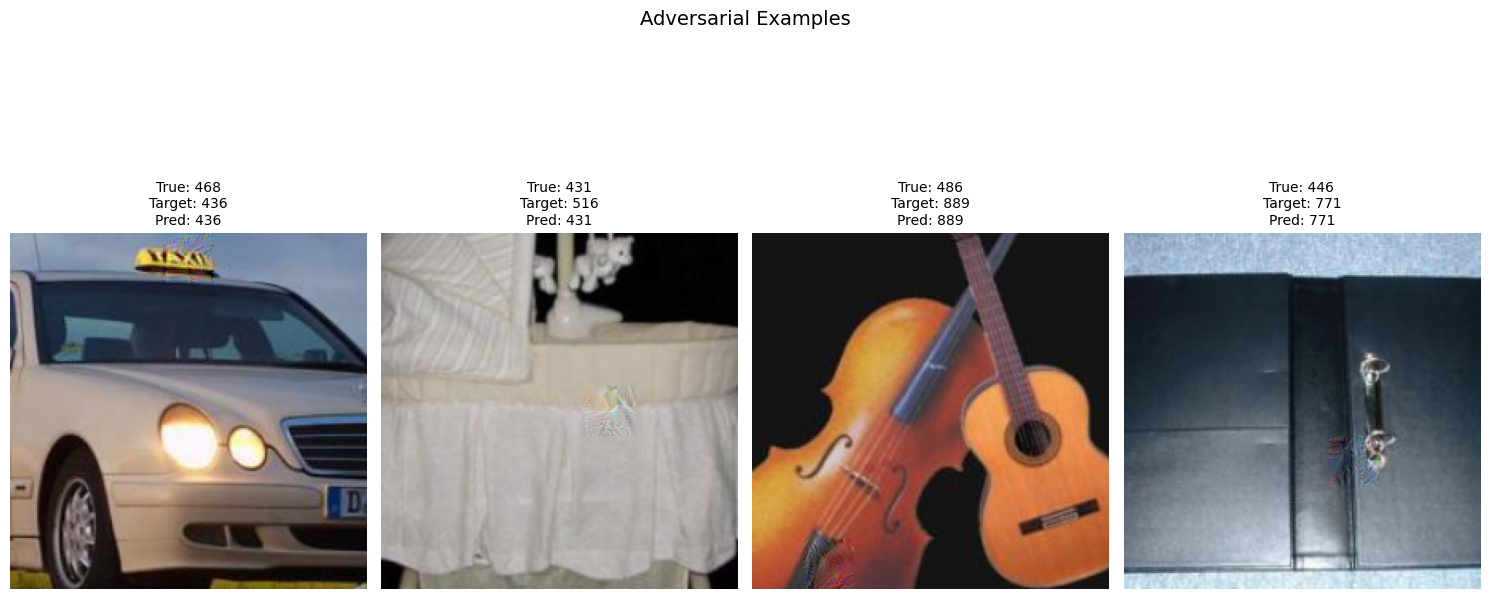

In [37]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random

# 1. Pick 5 random indices to display
num_samples = 4
indices     = random.sample(range(N), num_samples)

# 2. Load model output on those images
with torch.no_grad():
    imgs_subset = adv_dataset_images_task4[indices].to(device)
    logits      = model(imgs_subset)
    preds       = logits.topk(5, dim=1).indices.cpu()

# 3. Helper to de-normalize for display
def denorm(img):
    mean = torch.tensor(MEAN).view(3,1,1)
    std  = torch.tensor(STD).view(3,1,1)
    return (img.cpu() * std + mean).clamp(0,1)

# 4. Plot each image + prediction
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    img     = denorm(adv_dataset_images_task4[idx])
    true    = adv_dataset_labels_task4[idx].item()
    target  = adv_dataset_targets_task4[idx].item()
    pred_5  = preds[i].tolist()

    plt.subplot(1, num_samples, i+1)
    plt.imshow(TF.to_pil_image(img))
    plt.axis("off")
    title = f"True: {true}\nTarget: {target}\nPred: {pred_5[0]}"
    plt.title(title, fontsize=10)

plt.suptitle("Adversarial Examples", fontsize=14)
plt.tight_layout()
plt.show()


# Task 5

In [38]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = models.densenet121(
            weights=models.DenseNet121_Weights.IMAGENET1K_V1
        ).to(device).eval()

# build subset‑index → ImageNet‑ID REMAP
def build_remap(subset, wnid2idx):
    """Return torch.tensor where remap[i] = real ImageNet label for subset class i."""
    if isinstance(subset, dict):
        # make sure order is 0,1,2,…,k‑1
        subset = [subset[i] for i in sorted(subset.keys())]
    # subset is now an ordered list of WNIDs
    return torch.tensor([wnid2idx[wnid] for wnid in subset], dtype=torch.long)

remap = build_remap(subset_idx2wnid, wnid_to_idx)

def fix_labels(lbls):
    """Convert subset indices to full 0‑999 if needed."""
    if lbls.max() < len(remap):          # looks like subset indices (0…k‑1)
        return remap[lbls]
    return lbls                          # already 0‑999

# datasets from tast 1-4
datasets = [
    ("Clean",      orig_dataset_images,         fix_labels(orig_dataset_labels)),
    ("Adv Task 2", adv_dataset_images_task2,    fix_labels(adv_dataset_labels_task2)),
    ("Adv Task 3", adv_dataset_images_task3,    fix_labels(adv_dataset_labels_task3)),
    ("Adv Task 4", adv_dataset_images_task4,    fix_labels(adv_dataset_labels_task4)),
]

batch_size = 32

# evluation
for name, imgs, labels in datasets:
    dl = DataLoader(TensorDataset(imgs, labels), batch_size=batch_size, shuffle=False)

    top1 = top5 = n = 0
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device);  y = y.to(device)
            preds = model(x).topk(5, dim=1).indices   # [B,5]

            top1 += (preds[:, 0] == y).sum().item()
            top5 += (preds == y.unsqueeze(1)).any(1).sum().item()
            n    += x.size(0)

    print(f"{name:<12s}→ Top‑1 {top1/n:6.2%}   Top‑5 {top5/n:6.2%}")


Using cuda
Clean       → Top‑1 70.80%   Top‑5 91.20%
Adv Task 2  → Top‑1 59.00%   Top‑5 85.00%
Adv Task 3  → Top‑1 59.80%   Top‑5 87.60%
Adv Task 4  → Top‑1 65.00%   Top‑5 90.60%
